In [1]:
import time

In [2]:
#%%timeit -n 1 -r 1
start = time.perf_counter()

import torch

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

Elapsed time: 1.075143 seconds


In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Device Info

In [4]:
torch.__version__

'2.4.1'

In [5]:
torch.version.cuda

'12.4'

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.cuda.get_device_name()

'NVIDIA L40S'

In [8]:
torch.cuda.list_gpu_processes()

'GPU:0\nprocess       5037 uses      448.000 MB GPU memory'

In [9]:
torch.cuda.device_count()

1

In [10]:
# See https://github.com/seafoodfry/ml-workspace/blob/main/gpu-sandbox/our-cuda-by-example/03-cudaDeviceProp.cu
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA L40S', major=8, minor=9, total_memory=45372MB, multi_processor_count=142)

In [11]:
# See https://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/
torch.cuda.get_arch_list()

['sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']

In [12]:
# See
# https://pytorch.org/docs/stable/notes/cuda.html#optimizing-memory-usage-with-pytorch-cuda-alloc-conf
# and
# https://developer.nvidia.com/blog/using-cuda-stream-ordered-memory-allocator-part-1/
torch.cuda.get_allocator_backend()

'native'

In [13]:
# See https://pytorch.org/docs/stable/notes/mps.html
torch.backends.mps.is_available()

False

In [14]:
torch.backends.cuda.is_built()

True

In [15]:
torch.backends.cpu.get_cpu_capability()

'AVX2'

In [16]:
torch.tensor([1]).dtype

torch.int64

In [17]:
torch.tensor([1]).to(torch.float32).dtype

torch.float32

In [18]:
torch.tensor([1.0]).dtype

torch.float32

# Iris

In [19]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [20]:
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors.
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [21]:
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = IrisDataset(X_train, y_train)
test_dataset = IrisDataset(X_test, y_test)

In [22]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(
    test_dataset, batch_size=32, num_workers=0, drop_last=False)

In [23]:
for idx, (x, _) in enumerate(train_loader):
    print(f'Batch {idx}: ', x.shape)

Batch 0:  torch.Size([32, 2])
Batch 1:  torch.Size([32, 2])
Batch 2:  torch.Size([32, 2])
Batch 3:  torch.Size([24, 2])


In [24]:
class IrisClassifier(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()

        self.layers = torch.nn.Sequential(
            # 1st hidden layer.
            torch.nn.Linear(num_inputs, 30),
            torch.nn.ReLU(),
            
            # 2nd hidden layer.
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),
            
            # Output layer.
            torch.nn.Linear(20, num_outputs),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = IrisClassifier(2, 3)

In [25]:
if torch.cuda.is_available():
    _device = 'cuda'
elif torch.backends.mps.is_available():
    _device = 'mps'
else:
    _device = 'cpu'

_device

'cuda'

In [26]:
device = torch.device(_device)
device

device(type='cuda')

In [27]:
model = model.to(device)
model

IrisClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

model.train()
for epoch in range(num_epochs):
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        if (epoch) % 20 == 0:
            print(f'Epoch:{epoch:03d}/{num_epochs:03d}'
                  f' | Batch: {batch_idx:03d}/{len(train_loader):03d}'
                  f' | Train Loss: {loss:.3f}',
            )

Epoch:000/100 | Batch: 000/004 | Train Loss: 1.117
Epoch:000/100 | Batch: 001/004 | Train Loss: 1.034
Epoch:000/100 | Batch: 002/004 | Train Loss: 1.035
Epoch:000/100 | Batch: 003/004 | Train Loss: 1.001
Epoch:020/100 | Batch: 000/004 | Train Loss: 0.072
Epoch:020/100 | Batch: 001/004 | Train Loss: 0.064
Epoch:020/100 | Batch: 002/004 | Train Loss: 0.095
Epoch:020/100 | Batch: 003/004 | Train Loss: 0.078
Epoch:040/100 | Batch: 000/004 | Train Loss: 0.073
Epoch:040/100 | Batch: 001/004 | Train Loss: 0.127
Epoch:040/100 | Batch: 002/004 | Train Loss: 0.060
Epoch:040/100 | Batch: 003/004 | Train Loss: 0.024
Epoch:060/100 | Batch: 000/004 | Train Loss: 0.050
Epoch:060/100 | Batch: 001/004 | Train Loss: 0.037
Epoch:060/100 | Batch: 002/004 | Train Loss: 0.108
Epoch:060/100 | Batch: 003/004 | Train Loss: 0.080
Epoch:080/100 | Batch: 000/004 | Train Loss: 0.102
Epoch:080/100 | Batch: 001/004 | Train Loss: 0.062
Epoch:080/100 | Batch: 002/004 | Train Loss: 0.021
Epoch:080/100 | Batch: 003/004 

In [29]:
model.eval()

IrisClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [30]:
# numel returns the number of elements in a tensor.
num_params = 0
for idx, p in enumerate(model.parameters()):
    if p.requires_grad:
        params = p.numel()
        num_params += params
        print(f'({idx}) {params}')

print(f'Number of trainable parameters: {num_params}')

(0) 60
(1) 30
(2) 600
(3) 20
(4) 60
(5) 3
Number of trainable parameters: 773


In [31]:
with torch.no_grad():
    output = model(torch.tensor([0, 0], dtype=torch.float32, device=device))
output

tensor([-2.5866,  5.7973, -2.4930], device='cuda:0')

In [32]:
# Class membership probabilities.
torch.set_printoptions(sci_mode=False)
torch.softmax(output, dim=0)

tensor([    0.0002,     0.9995,     0.0003], device='cuda:0')

In [33]:
# Predictions. index 0 is for argmax of columns, index 1 is for argmax of the row.
# If we had a matrix of samples, then dim=1 would be the way to go but not here since we have a
# 1D tensor.
# Note that we don't need to apply this to the probabilities obtained from softmax.
torch.argmax(output, dim=0)

tensor(1, device='cuda:0')

In [34]:
# Taken from https://github.com/rasbt/machine-learning-book/blob/main/ch03/ch03.ipynb
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, device=device, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    #lab = classifier(np.array([xx1.ravel(), xx2.ravel()]).T)
    # UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow.
    # Please consider converting the list to a single numpy.ndarray with numpy.array()
    # before converting to a tensor.
    lab = classifier(
        torch.tensor(np.array([xx1.ravel(), xx2.ravel()]), dtype=torch.float32, device=device).T
    )
    #lab = lab.reshape(xx1.shape)
    _, predictions = torch.max(lab.data, 1)
    lab = predictions.cpu().detach().numpy()
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')

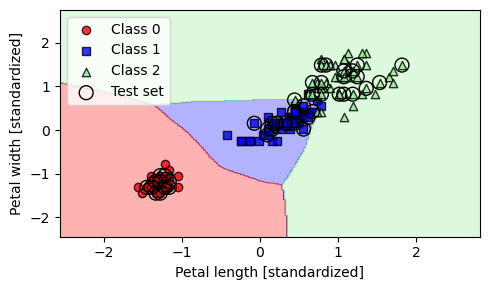

In [35]:
X_combined_std = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plt.figure(figsize=(5, 3))

with torch.no_grad():
    plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=model, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/03_01.png', dpi=300)
plt.show()

In [38]:
def compute_accuracy(model, dataloader, device=device):
    model = model.eval()

    correct = 0.0
    total_samples = 0
    for idx, (features, labels) in enumerate(dataloader):
        features, labels = features.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)
        correct += torch.sum( predictions == labels )
        total_samples += len(labels)
        
    return correct/total_samples

In [39]:
acc = compute_accuracy(model, test_loader)
acc.item()

1.0

## ONNX

In [40]:
X_train[:3, :]

tensor([[-1.5625, -1.3126],
        [-1.2760, -1.0456],
        [ 0.3859,  0.2892]])

In [41]:
X_train.shape

torch.Size([120, 2])

In [45]:
batch_size = 3
x_sample = torch.randn(batch_size, 2, requires_grad=True).to(device)
x_sample

tensor([[ 0.0828, -1.5232],
        [-1.4958,  0.1866],
        [-1.6016,  0.4938]], device='cuda:0', grad_fn=<ToCopyBackward0>)

In [46]:
x_sample.shape

torch.Size([3, 2])

In [47]:
model.eval()

with torch.no_grad():
    torch_out = model(x_sample)

In [48]:
torch.onnx.producer_version

'2.4.1'

In [49]:
# See https://onnxruntime.ai/docs/reference/compatibility.html
# for ONNX opset support.
# See https://pytorch.org/docs/stable/onnx_torchscript_supported_aten_ops.html
# for ONNX supported TorchScript operators.
torch.onnx._constants.ONNX_MAX_OPSET

20

In [57]:
%%bash

# See
# https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html
# for ONNX - CUDA - CUDNN compatibility notes.
pip uninstall -y onnxruntime onnxruntime-gpu

#pip install onnx onnxruntime-gpu==1.18.0

In [50]:
!pip install onnxruntime-gpu

In [51]:
!conda update -y -n base -c conda-forge conda

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done

# All requested packages already installed.



In [52]:
%%bash

conda install -y onnx

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



In [53]:
!conda install -y onnxruntime

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done

# All requested packages already installed.



In [54]:
%%bash

# TensorRT installation guide
# https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html
# GitHub repo
# https://github.com/nvidia/tensorrt
# Downgrading setuptools 'cas of:
# https://github.com/pypa/setuptools/issues/4483#issuecomment-2430620456
pip install --upgrade setuptools==70.0.0
pip install tensorrt

In [55]:
!pip list | grep onnx

onnx                               1.17.0
onnxruntime-gpu                    1.20.1


In [56]:
!pip list | grep tensor

tensorrt                           10.6.0.post1
tensorrt-cu12                      10.6.0.post1
tensorrt-cu12-bindings             10.6.0.post1
tensorrt-cu12-libs                 10.6.0.post1


In [57]:
!pip list | grep setup

setuptools                         70.0.0


In [58]:
!cat /usr/local/cuda/include/cudnn_version.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 8
#define CUDNN_MINOR 9
#define CUDNN_PATCHLEVEL 7
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

/* cannot use constexpr here since this is a C-only file */


In [59]:
import tensorrt
tensorrt.__version__

'10.6.0.post1'

In [61]:
# Export the model.
torch.onnx.export(
    model,              # model being run
    x_sample,                  # model input (or a tuple for multiple inputs)
    'simple-iris.onnx',        # where to save the model (can be a file or file-like object)
    export_params=True,        # store the trained parameter weights inside the model file
    opset_version=20,          # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names = ['iris_input'],   # the model's input names
    output_names = ['iris_output'], # the model's output names
    dynamic_axes={
        'iris_input' : {0 : 'batch_size'},    # variable length axes.
        'iris_output' : {0 : 'batch_size'},
    },
)

## Using an ONNX Model

In [62]:
import onnx
import onnxruntime as ort

In [63]:
onnx_model = onnx.load('simple-iris.onnx')

# Verify the model’s structure and confirm that the model has a valid schema.
# The validity of the ONNX graph is verified by checking the model’s version,
# the graph’s structure, as well as the nodes and their inputs and outputs.
onnx.checker.check_model(onnx_model)

In [64]:
!nvidia-smi

Wed Nov 27 01:53:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    On  |   00000000:30:00.0 Off |                    0 |
| N/A   38C    P0             81W /  350W |    1016MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [65]:
ort.get_available_providers()

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']

In [66]:
ort.__version__

'1.20.1'

In [67]:
ort.get_device()

'GPU'

In [69]:
ort_session = ort.InferenceSession(
    'simple-iris.onnx',
    providers=['CUDAExecutionProvider'],
)

In [70]:
ort_session = ort.InferenceSession(
    'simple-iris.onnx',
    providers=['TensorrtExecutionProvider'],
)

In [71]:
torch.backends.cudnn.enabled

True

In [72]:
torch.backends.cudnn.version()

90300

In [73]:
import torch._C as _C
torch_lib_path = _C.__file__
print("Torch library path:", torch_lib_path)
print("\nDependencies:")
!ldd {torch_lib_path} | grep cudnn

Torch library path: /opt/conda/envs/pytorch/lib/python3.11/site-packages/torch/_C.cpython-311-x86_64-linux-gnu.so

Dependencies:
	libcudnn.so.9 => /opt/conda/envs/pytorch/lib/python3.11/site-packages/torch/lib/libcudnn.so.9 (0x0000754c42c00000)


In [74]:
!which pip

/opt/conda/envs/pytorch/bin/pip


In [75]:
ort_session.get_inputs(), ort_session.get_outputs()

([<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg at 0x73e44f7b9df0>],
 [<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg at 0x73e44f7b8a70>])

In [76]:
input_name = ort_session.get_inputs()[0].name
input_name

'iris_input'

In [77]:
output_name = ort_session.get_outputs()[0].name
output_name

'iris_output'

In [78]:
pred_onx = ort_session.run([output_name], {input_name: np.array([[0, 0]]).astype(np.float32)})
pred_onx

[array([[-2.5866406,  5.797317 , -2.4929612]], dtype=float32)]

In [79]:
madeup_batch = np.array(
    [
        [0, 0],
        [0.1, 0.1],
    ]
    ).astype(np.float32)
pred_onx = ort_session.run([output_name], {input_name:madeup_batch})
pred_onx

[array([[-2.5866406,  5.7973175, -2.4929612],
        [-3.0085957,  5.8048453, -2.0900805]], dtype=float32)]